## Automatic Differentiation via Contour Integration: 

## 1. The Cauchy Integral Formula for computing derivatives: 

In [1]:
function nabla(f, x::Float64, delta::Float64)

  N = round(Int,2*pi/delta)
  thetas = vcat(1:N)*delta

  ## collect arguments and rotations: 
  rotations = map(theta -> exp(-im*theta),thetas)
  arguments = x .+ conj.(rotations)  

  ## calculate expectation: 
  expectation = 1.0/N*real(sum(map(f,arguments).*rotations))

  return expectation

end

nabla (generic function with 1 method)

## 2. A few test cases: 

### a. A few test functions of a single variable including compositions of functions:

In [2]:
cosh_(x) = (exp(x)+exp(-x))/2

g(x) = (x-1)^2 + (x-2)^4 + (x-3)^6

h(x) = cos(x)

l = g ∘ h

m = g ∘ cosh_

#52 (generic function with 1 method)

### b. Test it on cosine: 

In [3]:
delta = (2*pi)/1000

nabla(h, pi/2, delta)

-1.0000000000000016

### c. Test it on compositions of functions:

In [4]:
delta = (2*pi)/1000

nabla(m, 1.0, delta) 

-45.45705185890576

#### Wolfram Alpha agrees with the above calculations. A good sign.

## 3. Using the Cauchy Integral Formula to perform gradient descent: 

In [5]:
function gradient_descent(f,x_p::Float64,alpha::Float64)

  ## 100 steps
  for i=1:100

    x_n = x_p - alpha*nabla(f,x_p,delta)
    x_p = x_n

  end

  return x_p

end

gradient_descent (generic function with 1 method)

In [6]:
## initial value: 
x_p = 5.0 

## learning rate: 
alpha = 0.01 

x_min = gradient_descent(g,x_p,alpha)

2.1702275657206824

In [7]:
## check solution: 

g(x_min)

1.6966751541950713

## 4. Using the Cauchy Integral Formula to compute Partial Derivatives: 

#### a. Define a function of several variables, in this case three: 

In [8]:
q(X) = X[1] + X[2]^2 + cos(X[3])

## kronecker delta, which will come in handy:

kd(i,n) = [j==i for j in 1:n]

## use q to create three functions of a single variable where 
## all the other variables are held constant: 

q1 = x -> q(x*kd(1,3) .+ X.*(ones(3)-kd(1,3)))

q2 = x -> q(x*kd(2,3) .+ X.*(ones(3)-kd(2,3)))

q3 = x -> q(x*kd(3,3) .+ X.*(ones(3)-kd(3,3)))

#11 (generic function with 1 method)

#### b. Compute all three partial derivatives:

In [9]:
## computations are done with respect to a point X:
X = [0.0,0.0,pi/2.0]

3-element Array{Float64,1}:
 0.0               
 0.0               
 1.5707963267948966

In [10]:
## first partial derivative: 
nabla(q1,X[1],delta)

1.0

In [11]:
## second partial derivative: 
nabla(q2,X[2],delta)

-1.1324274851176598e-17

In [12]:
## third partial derivative:
nabla(q3,X[3],delta)

-1.0000000000000016

## 5. The case where we have some uncertainty about the function to be evaluated: 

In [13]:
### If we are uncertain about f, which is generally the case, a more refined grid over [0,2*pi] may 
### actually yield a more biased answer so it may be better to use noise present in the biological 
### system to come up with a cheap and fast monte-carlo estimate.

### This motivates the definition of monte-carlo gradients using half the usual number of points and the definition
### of the gradient as an expected value:

function mc_nabla(f, x::Float64, delta::Float64)

  N = round(Int,2*pi/delta)

  ## sample with only half the number of points: 
  sample = rand(1:N,round(Int,N/2)) 
  thetas = sample*delta

  ## collect arguments and rotations: 
  rotations = map(theta -> exp(-im*theta),thetas)
  arguments = x .+ conj.(rotations)  

  ## calculate expectation: 
  expectation = 2.0/N*real(sum(map(f,arguments).*rotations))

  return expectation

end

mc_nabla (generic function with 1 method)

## 6. Simulating a spring pendulum using the Euler-Lagrange equations: 

### a. We define the Lagrangian then proceed as we did for calculating partial derivatives earlier: 

In [14]:
## The Lagrangian where we assume the length of the unextended spring is 1.0 and mass is 1.0 kg:
M, l, K = 1.0, 1.0, 1.0

L(X) = 0.5*M*(X[3]^2+(l+X[1])^2*X[4]^2)+M*9.8*(l+X[1])*cos(X[2])-0.5*K*X[1]^2

## kronecker delta, which will come in handy:
kd(i,n) = [j==i for j in 1:n]

##  All four variables will be stored in this array:
Z = zeros(150,4)

## The initial conditions: 
Z[1,:] = [1.0,pi/4,1.0,1.0]

4-element Array{Float64,1}:
 1.0               
 0.7853981633974483
 1.0               
 1.0               

### b. Simulate the spring pendulum using the leapfrog method: 

In [15]:
delta = (2*pi)/1000

dt = 0.01

## simulate the pendulum system: 
for i=1:149

	## apply kronecker delta so we can compute partial derivatives: 
	dd_theta = x -> L(x*kd(2,4) .+ Z[i,:].*(ones(4)-kd(2,4)))

	dd_x = x -> L(x*kd(1,4) .+ Z[i,:].*(ones(4)-kd(1,4)))

	## update angle: 
	Z[i+1,1] = Z[i,1] + Z[i,3]*dt + 0.5*(nabla(dd_x,Z[i,1],delta))*dt^2

	## update position: 
	Z[i+1,2] = Z[i,2] + Z[i,4]*dt + 0.5*(nabla(dd_theta,Z[i,2],delta))*dt^2

	## update derivatives:
	Z[i+1,3] = Z[i,3] + 0.5*(nabla(dd_x,Z[i,1],delta)+nabla(dd_x,Z[i+1,1],delta))*dt

	Z[i+1,4] = Z[i,4] + 0.5*(nabla(dd_theta,Z[i,2],delta)+nabla(dd_theta,Z[i+1,2],delta))*dt

end

### c. Visualising the system: 

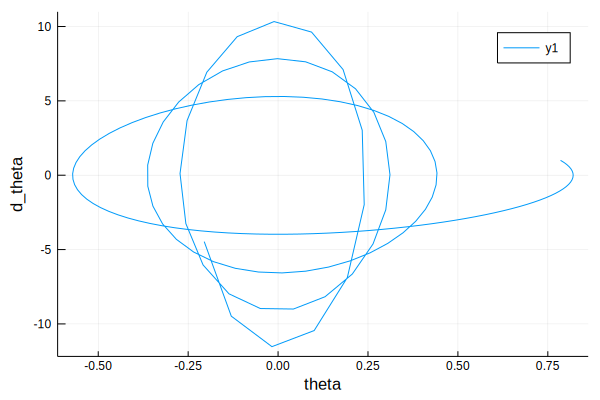

In [16]:
using Plots

## plotting angular velocity(dtheta) against angle(theta): 
plot(Z[:,2],Z[:,4])

xlabel!("theta")
ylabel!("d_theta")